In [12]:
# -*- coding: utf-8 -*- 
# This code is written in Python 3.7. To install the required packages, run the following commands:
# pip install pandas numpy matplotlib seaborn scikit-learn sympy
# This code is applicable to the Simargl 2022 dataset. 
# implemented Advanced Ensemble techniques: Bagging

import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import confusion_matrix
import seaborn as sns
import tensorflow as tf
import numpy as np
from sklearn.preprocessing import LabelEncoder

In [13]:
# Load the cleaned Simargl 2022 dataset
df = pd.read_csv(
    '/home/ibibers@ads.iu.edu/IDS_Datasets/Combined_datasets/Simargl_cleaned_dataset.csv')

tf.keras.backend.clear_session()

In [14]:
# Set the desired number of records for 'Normal' and 'Denial of Service' labels
desired_records_normal = 500000  # Change this to your desired number for 'Normal'
desired_records_dos = 3000000  # Change this to your desired number for 'Denial of Service'

# Filter data for 'Normal' and 'Denial of Service'
subset_df_normal = df[df['ALERT'] == 'Normal']
subset_df_dos = df[df['ALERT'] == 'Denial of Service']

# Sample the desired number of records from each class
subset_df_normal_sampled = subset_df_normal.sample(n=desired_records_normal, random_state=42)
subset_df_dos_sampled = subset_df_dos.sample(n=desired_records_dos, random_state=42)

# Combine the subsets with the rest of the data
final_subset = pd.concat([subset_df_normal_sampled, subset_df_dos_sampled, df[df['ALERT'] != 'Normal'][df['ALERT'] != 'Denial of Service']])

# Optional: Shuffle the final subset
final_subset = final_subset.sample(frac=1, random_state=42)


/tmp/ipykernel_2383232/364247859.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  final_subset = pd.concat([subset_df_normal_sampled, subset_df_dos_sampled, df[df['ALERT'] != 'Normal'][df['ALERT'] != 'Denial of Service']])


In [15]:
# Extract subsample of data
print(" Extract subsample of data: ")
print(final_subset['ALERT'].value_counts())

 Extract subsample of data: 
ALERT
Port Scanning        4170194
Denial of Service    3000000
Normal                500000
Malware                  571
Name: count, dtype: int64


In [16]:
# Extract subsample of data
print(" Extract subsample of data: ")
print(df['ALERT'].value_counts())

 Extract subsample of data: 
ALERT
Normal               15049330
Denial of Service     5138973
Port Scanning         4170194
Malware                   571
Name: count, dtype: int64


In [17]:
dropped_df = ['ALERT']
X = final_subset.drop(dropped_df, axis=1)
y = final_subset['ALERT']

label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

print(final_subset['ALERT'].value_counts())

ALERT
Port Scanning        4170194
Denial of Service    3000000
Normal                500000
Malware                  571
Name: count, dtype: int64


In [19]:
# Initial train test split set and split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y)


In [20]:
# Initialize MirroredStrategy for GPU acceleration
strategy = tf.distribute.MirroredStrategy()

# Train the models
with strategy.scope():
    # Define various base models
    base_models = [
        RandomForestClassifier(random_state=42),
        MLPClassifier(random_state=42),
        LogisticRegression(random_state=42),
        DecisionTreeClassifier(random_state=42)
    ]
    
    # Create a Bagging Classifier with diverse base models
    # Bagging is an ensemble technique that combines predictions from multiple models, and is effective in reducing overfitting.
    bagging_model = BaggingClassifier(
        base_models[0], n_estimators=len(base_models), random_state=42)

    # Train the bagging model
    bagging_model.fit(X_train, y_train)

    # Make predictions on the test set
    y_pred_enc = bagging_model.predict(X_test)


INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')


2024-03-04 22:29:15.692207: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1929] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 1046 MB memory:  -> device: 0, name: NVIDIA RTX A6000, pci bus id: 0000:67:00.0, compute capability: 8.6
2024-03-04 22:29:15.692910: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1929] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 1047 MB memory:  -> device: 1, name: NVIDIA RTX A6000, pci bus id: 0000:68:00.0, compute capability: 8.6


In [21]:
# Evaluate the model
accuracy = accuracy_score(y_test, y_pred_enc)
print(f"Accuracy: {accuracy}")

Accuracy: 1.0


In [22]:
# Use inverse_transform to get original labels
y_pred = label_encoder.inverse_transform(y_pred_enc)
y_test_labels = label_encoder.inverse_transform(y_test)

# Classification Report
print("\nClassification Report:")
print(classification_report(y_test_labels, y_pred))


Classification Report:
                   precision    recall  f1-score   support

Denial of Service       1.00      1.00      1.00    600000
          Malware       1.00      1.00      1.00       114
           Normal       1.00      1.00      1.00    100000
    Port Scanning       1.00      1.00      1.00    834039

         accuracy                           1.00   1534153
        macro avg       1.00      1.00      1.00   1534153
     weighted avg       1.00      1.00      1.00   1534153



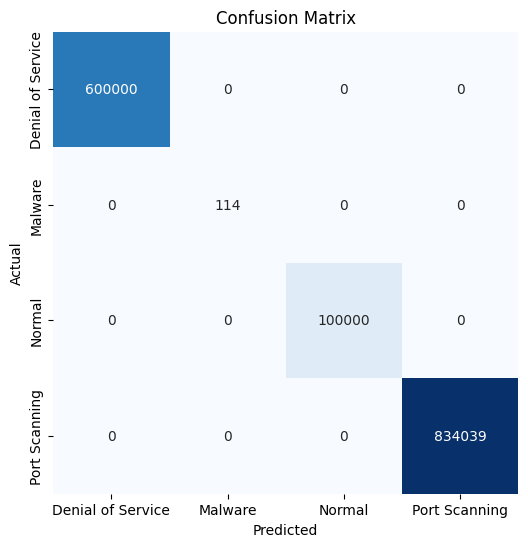

In [23]:
# Confusion matrix with string labels
conf_mat = confusion_matrix(y_test_labels, y_pred)

# Get unique class labels from y_test and y_pred_encoded
unique_labels = np.unique(np.concatenate(
    (y_test_labels, y_pred)))

# Plotting the Confusion Matrix with class labels
plt.figure(figsize=(6, 6))
sns.heatmap(conf_mat, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=unique_labels, yticklabels=unique_labels)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

/tmp/ipykernel_2383232/1985897278.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=sorted_importance.values,


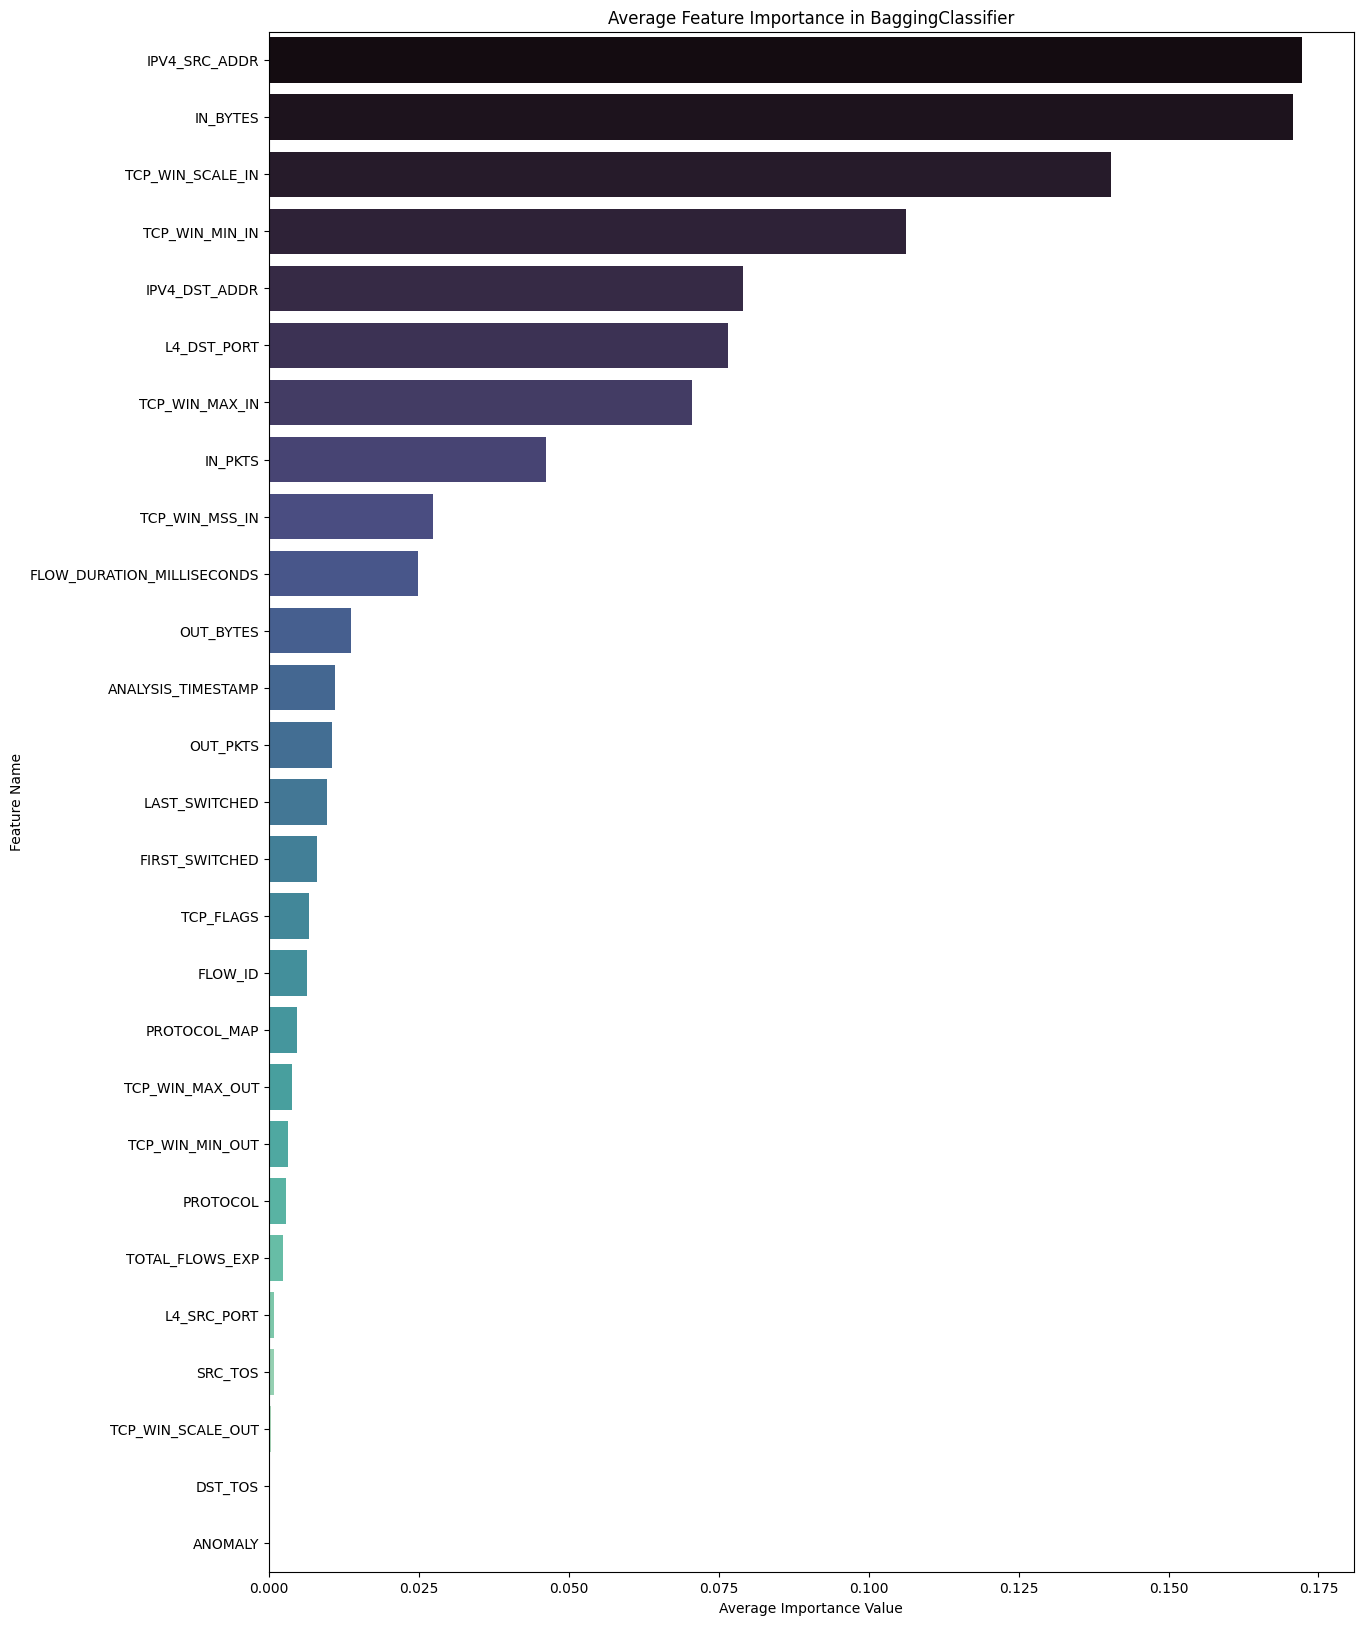

In [24]:
# Extract feature importances from base models
base_models_importances = {}

for i, model in enumerate(bagging_model.estimators_):
    if hasattr(model, 'feature_importances_'):
        base_models_importances[f'base_model_{i}'] = model.feature_importances_

# Create a DataFrame for visualization
importance_df = pd.DataFrame(base_models_importances, index=X.columns)

# Calculate average feature importance across base models
average_importance = importance_df.mean(axis=1)

# Sort features by average importance
sorted_importance = average_importance.sort_values(ascending=False)

# Visualize the feature importances
plt.figure(figsize=(14, 20))
sns.barplot(x=sorted_importance.values,
            y=sorted_importance.index, palette='mako')
plt.xlabel('Average Importance Value')
plt.ylabel('Feature Name')
plt.title('Average Feature Importance in BaggingClassifier')
plt.show()